In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Load the dataset
confirm = pd.read_csv('confirmed_rate_us.csv')
vaccine_tweet_sent = pd.read_csv('vaccine_tweet_sent_nozero.csv')
all_tweet_sent = pd.read_csv('2020_2022_all_sent.csv')
death = pd.read_csv('deaths_rate_us.csv')

In [3]:
vaccine_tweet_sent = vaccine_tweet_sent.rename(columns={'date': 'Date'})
all_tweet_sent = all_tweet_sent.drop('Unnamed: 0', axis=1)
negative_sentiment = all_tweet_sent[all_tweet_sent['Sentiment'] == 'negative']
neutral_sentiment = all_tweet_sent[all_tweet_sent['Sentiment'] == 'neutral']
positive_sentiment = all_tweet_sent[all_tweet_sent['Sentiment'] == 'positive']

In [4]:
input_format = "%m/%d/%Y"  # The format of date_str_1
output_format = "%Y-%m-%d"  # The desired format
confirm['Date'] = confirm['Date'].apply(lambda x: datetime.strptime(x, input_format).strftime(output_format))

In [5]:
death['Date'] = death['Date'].apply(lambda x: datetime.strptime(x, input_format).strftime(output_format))

In [6]:
confirm = confirm.drop('increased', axis=1)

In [7]:
death = death.drop('fast', axis=1)
death = death.rename(columns={'diff': 'death_diff'})

In [8]:
confirm = confirm.drop('Unnamed: 0', axis=1)
death = death.drop('Unnamed: 0', axis=1)

In [9]:
df = confirm.merge(negative_sentiment, on='Date', how='inner').merge(
    death, on='Date', how='inner').merge(
    vaccine_tweet_sent, on='Date', how='inner')

In [10]:
df = df.drop(['Year', 'Month', 'Day', 'Sentiment', 'index'], axis=1)
df = df.rename(columns={'Count': 'Count_all_tweets_negative', 'Avg_Per': 'Avg_Per_all_tweets_negative', 
                        'sum_sentiment_score': 'sum_sent_vaccine_Tweets',
                        'avg_sentiment_score': 'avg_sent_vaccine_Tweets',
                        'tweet_count': 'tweet_count_vaccine_Tweets',
                       })

In [11]:
df = df.drop_duplicates()

In [12]:
df['confirm_diff'] = df['confirmed_us'] - df['yesterday_confirmed_us']

In [13]:
df = df.merge(neutral_sentiment, on='Date', how='inner')
df = df.drop(['Year', 'Month', 'Day', 'Sentiment'], axis=1)
df = df.rename(columns={'Count': 'Count_all_tweets_neutral', 
                        'Avg_Per': 'Avg_Per_all_tweets_neutral', 
                       })

In [14]:
df = df.merge(positive_sentiment, on='Date', how='inner')
df = df.drop(['Year', 'Month', 'Day', 'Sentiment'], axis=1)
df = df.rename(columns={'Count': 'Count_all_tweets_positive', 
                        'Avg_Per': 'Avg_Per_all_tweets_positive', 
                       })


In [15]:
df = df.drop(['Date',], axis=1)

In [16]:
df.head()

,confirmed_rate_us,confirmed_us,yesterday_confirmed_us,Count_all_tweets_negative,Avg_Per_all_tweets_negative,deaths_rate_us,deaths_us,yesterday_deaths_us,death_diff,sum_sent_vaccine_Tweets,avg_sent_vaccine_Tweets,tweet_count_vaccine_Tweets,confirm_diff,Count_all_tweets_neutral,Avg_Per_all_tweets_neutral,Count_all_tweets_positive,Avg_Per_all_tweets_positive
0,3.650324e-08,12,12.0,84573,0.784561,3.041937e-09,1,1.0,0.0,-3.423437,-0.085586,40,0.0,14560,0.136399,8533,0.079039
1,1.916420e-06,630,538.0,115926,0.819362,7.300649e-08,24,22.0,2.0,-9.808869,-0.132552,74,92.0,15473,0.109645,10644,0.070993
2,1.449419e-03,476479,440933.0,252685,0.845454,6.515829e-05,21420,19215.0,2205.0,-5.198317,-0.148523,35,35546.0,27470,0.097254,16849,0.057292
3,3.991474e-03,1312149,1287687.0,294714,0.813475,2.492441e-04,81936,80472.0,1464.0,2.607551,0.096576,27,24462.0,44074,0.122688,22807,0.063837
4,6.002237e-03,1973163,1952876.0,588829,0.838050,3.488554e-04,114682,113768.0,914.0,0.822600,0.091400,9,20287.0,72884,0.102723,40052,0.059227


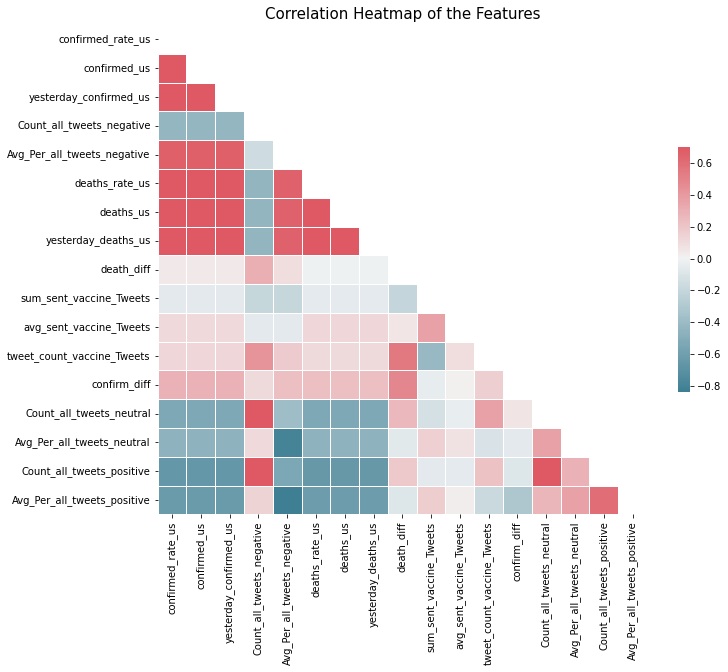

In [17]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Choose a different colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of the Features', fontsize=15)
plt.show()

'avg_sent_vaccine_Tweets','tweet_count_vaccine_Tweets','Count_all_tweets_neutral',
'Count_all_tweets_positive','Avg_Per_all_tweets_negative','Count_all_tweets_negative'

In [18]:
#Feature engineering
df['tweet_count_vaccine_Tweets_sqrt']=np.sqrt(df['tweet_count_vaccine_Tweets'])
df['tweet_count_vaccine_Tweets_sqr']=df['tweet_count_vaccine_Tweets']**2
df['tweet_count_vaccine_Tweets_log']=np.log(df['tweet_count_vaccine_Tweets'])

df['Count_all_tweets_neu&pos&neg-avg']=(df['Count_all_tweets_neutral']
                                        +df['Count_all_tweets_positive']+df['Count_all_tweets_negative'])/3

df['interaction_vaccine_tweets_sent'] = df['tweet_count_vaccine_Tweets'] * df['avg_sent_vaccine_Tweets']

df['squared_avg_sent_vaccine_Tweets'] = df['avg_sent_vaccine_Tweets'] ** 2
df['cubed_tweet_count_vaccine_Tweets'] = df['tweet_count_vaccine_Tweets'] ** 3

df['ratio_negative_neutral_tweets'] = df['Count_all_tweets_negative'] / df['Count_all_tweets_neutral']
df['ratio_positive_negative_tweets'] = df['Count_all_tweets_positive'] / df['Count_all_tweets_negative']


In [19]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# remove any data points that fall outside of the IQR
df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()



Data selection:

In [20]:

X = df_clean[['avg_sent_vaccine_Tweets',#average of sentiment score of vaccine tweets
              'tweet_count_vaccine_Tweets',#count of vaccine tweets
                'Count_all_tweets_neutral',#count of All covid neutral tweets
                'Count_all_tweets_positive',#count of All covid positive tweets
                'Avg_Per_all_tweets_negative',#average percent of All covid negative tweets
              'Count_all_tweets_neu&pos&neg-avg',#average count of All covid 3 kind of tweets
                'Count_all_tweets_negative',#count of All covid negative tweets
                'squared_avg_sent_vaccine_Tweets',#squared average of sentiment score of vaccine tweets
              'cubed_tweet_count_vaccine_Tweets',#cubed average of sentiment score of vaccine tweets
              'interaction_vaccine_tweets_sent',#interaction between the count of vaccine tweets and the sentiment scores
             'ratio_negative_neutral_tweets',
              'ratio_positive_negative_tweets',
              
              
             ]]
y = df_clean['confirm_diff']

Create a Ridge regression model for daily increased comfirmed cases:

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Ridge regression model with L2 regularization
# Here we're setting the regularization strength to 1.0, you can adjust this value
model = Ridge(alpha=500)
# Train the model
model.fit(X_train, y_train)
# Use the model to make predictions on the testing data
y_pred = model.predict(X_test)
# Print the root mean squared error of the model
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))


Root Mean Squared Error: 53906.94569261472
R-squared: 0.004575441208670372
Cross-validation scores: [-0.05118921 -0.14757396 -0.02680331  0.04845433 -0.07213818]
Average cross-validation score: -0.049850064879817066


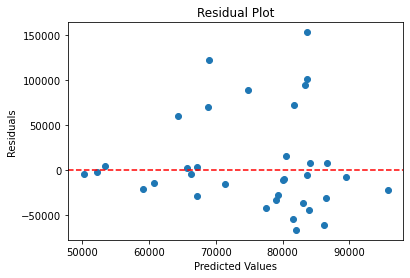

In [22]:
residuals = y_test - y_pred

# Plot the residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [23]:
coefficients = model.coef_

# If you're working with a DataFrame, you can create a new DataFrame to display the features and their corresponding coefficients
coef_df = pd.DataFrame(coefficients, columns=['Coefficient'], index=X.columns)

print(coef_df)

                                  Coefficient
avg_sent_vaccine_Tweets            -23.991740
tweet_count_vaccine_Tweets         -16.607996
Count_all_tweets_neutral            -1.220135
Count_all_tweets_positive            0.346647
Avg_Per_all_tweets_negative          3.602565
Count_all_tweets_neu&pos&neg-avg    -0.234014
Count_all_tweets_negative            0.171447
squared_avg_sent_vaccine_Tweets    -13.100239
cubed_tweet_count_vaccine_Tweets     0.000228
interaction_vaccine_tweets_sent   -109.638476
ratio_negative_neutral_tweets      562.287203
ratio_positive_negative_tweets       3.801703


In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# add a constant term to your features (required for VIF calculation)
X_const = sm.add_constant(X)

# calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(X.shape[1])]

print(vif)


                            Variable        VIF
0            avg_sent_vaccine_Tweets   2.906632
1         tweet_count_vaccine_Tweets   8.628182
2           Count_all_tweets_neutral        inf
3          Count_all_tweets_positive        inf
4        Avg_Per_all_tweets_negative  30.762072
5   Count_all_tweets_neu&pos&neg-avg        inf
6          Count_all_tweets_negative        inf
7    squared_avg_sent_vaccine_Tweets   1.405806
8   cubed_tweet_count_vaccine_Tweets   7.539044
9    interaction_vaccine_tweets_sent   3.331701
10     ratio_negative_neutral_tweets  17.343623
11    ratio_positive_negative_tweets  17.436211


D:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Create a Ridge regression model for daily increased Death cases:

In [25]:
# Select the features


X = df_clean[['avg_sent_vaccine_Tweets',#average of sentiment score of vaccine tweets
              'tweet_count_vaccine_Tweets',#count of vaccine tweets
                'Count_all_tweets_neutral',#count of All covid neutral tweets
                'Count_all_tweets_positive',#count of All covid positive tweets
                'Avg_Per_all_tweets_negative',#average percent of All covid negative tweets
              'Count_all_tweets_neu&pos&neg-avg',#average count of All covid 3 kind of tweets
                'Count_all_tweets_negative',#count of All covid negative tweets
                'squared_avg_sent_vaccine_Tweets',#squared average of sentiment score of vaccine tweets
              'cubed_tweet_count_vaccine_Tweets',#cubed average of sentiment score of vaccine tweets
              'interaction_vaccine_tweets_sent',#interaction between the count of vaccine tweets and the sentiment scores
             'ratio_negative_neutral_tweets',
              'ratio_positive_negative_tweets',]]
y = df_clean['death_diff']



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()




# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Ridge regression model with L2 regularization
# Here we're setting the regularization strength to 1.0, you can adjust this value
model = Ridge(alpha=500)
# Train the model
model.fit(X_train, y_train)
# Use the model to make predictions on the testing data
y_pred = model.predict(X_test)
# Print the root mean squared error of the model
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))



Root Mean Squared Error: 618.9691212478901


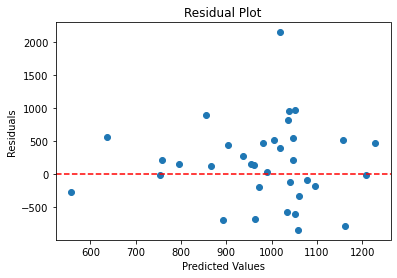

In [26]:
residuals = y_test - y_pred

# Plot the residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()